## Speech to Emotion coefficients Estimation using Conventional Neural Network

Arthur : Suradej Duangpumet ,JAIST
Date : Nov 24, 2018

### Import library

In [1]:
import os
import numpy as np 
import random
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
# --- Signal Processing 
from scipy.io import wavfile
from scipy.signal import butter, lfilter, freqz, hilbert, filtfilt, convolve 
import scipy 
import IPython.display as ipd
# --- Spectrogram-------------------
import librosa
import librosa.display
#-----------------------------
from sklearn.model_selection import train_test_split,cross_val_score
import keras
from sklearn import metrics
from sklearn import linear_model
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# --- Machine Learining : TensorFlow
from keras.layers import Dense, Input, Flatten
from keras.models import Model
from keras.layers import Dropout
from keras.optimizers import SGD,RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

from keras.models import load_model
from keras.models import model_from_json

Using TensorFlow backend.


## load signals

In [2]:
wav_path = "speechSignals/"  
files = os.listdir(wav_path)
#Allocating memory for dataset
WAV = np.zeros([len(files),96000]) #Sampling rate 16kS/s, 3 seconds long.

In [3]:
WAV[0].shape

(96000,)

In [4]:
j = 0
for fname in files:               
    signal, Fs = librosa.load(wav_path+fname)
    X = np.array(signal)
    if len(X)<96000:
        Xpad = np.pad(X, (0, 96000-len(X)), mode='constant')#Padding to make the same length
        WAV[j]=np.array(Xpad)
    else:
        X = X[1:96001]
        WAV[j]=np.array(X)
        
    j += 1
                
#save to numpy files
np.save('speechData',WAV)  # We can save the dataset to any name as "Ey_clean.npy"

Test loaded signal

In [5]:
ipd.Audio(WAV[0], rate=Fs) 

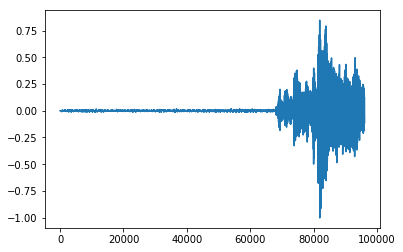

In [6]:
plt.plot(WAV[0])

## load Label (Coefficients)

initialized variables

In [11]:
coef_1 = np.zeros([len(files),1])
coef_2 = np.zeros([len(files),1])
coef_3 = np.zeros([len(files),1])  

In [12]:
coefdata = np.genfromtxt('Emotion_Coefficients.csv',delimiter=',')

In [14]:
coef_1 = coefdata[:,0]
coef_2 = coefdata[:,1]
coef_3 = coefdata[:,2]

In [23]:
coef_1[1]

0.027310000000000001

In [24]:
coef = np.zeros([len(files),3])

In [28]:
for i in range(len(files)):
    coef[i] = [coef_1[i], coef_2[i], coef_3[i]]

In [29]:
coef.shape

(20, 3)

In [30]:
coef[0]

array([  6.32000000e-03,   5.38000000e-01,   6.57500000e+00])

## Using STFT to convert vector to be two-diemension data called Spectrogram

### display spectrogram of a signal

C:\Users\T470s\Miniconda2\envs\tfdeeplearning\lib\site-packages\librosa\core\spectrum.py:183: ComplexWarning: Casting complex values to real discards the imaginary part
  axis=0)[:stft_matrix.shape[0]]


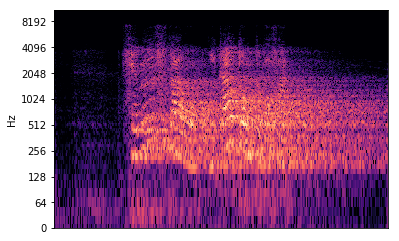

In [31]:
Spectrogram1 = librosa.amplitude_to_db(librosa.stft(WAV[1],n_fft=1024,dtype='float32'),ref=np.max)
librosa.display.specshow(Spectrogram1, y_axis='log')

Show the dimenstion of time and frequency of the spectrogram

In [32]:
Spectrogram1.shape

(513, 376)

Convert all signals to Spectrograms

In [33]:
Spectrogram = np.zeros([len(files),513, 376])

In [34]:
Spectrogram.shape

(20, 513, 376)

In [35]:
i = 0
for i in range(len(files)):
    Spectrogram[i] = librosa.amplitude_to_db(librosa.stft(WAV[i],n_fft=1024,dtype='float32'),ref=np.max)

C:\Users\T470s\Miniconda2\envs\tfdeeplearning\lib\site-packages\librosa\core\spectrum.py:183: ComplexWarning: Casting complex values to real discards the imaginary part
  axis=0)[:stft_matrix.shape[0]]


reshaping and formating the dataset

In [36]:
x_train = np.reshape(Spectrogram,[Spectrogram.shape[0],513, 376,1])
x_test = np.reshape(Spectrogram,[Spectrogram.shape[0],513,376,1])
x_train = x_train.astype('float32') # convert to float32
x_test = x_test.astype('float32') 

In [37]:
y_train = coef
y_test = y_train #Just for demo only, it should be spited from all data
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

## Constructing CNN model

In [38]:
# build model
inputCNN = Input(shape=(513,376,1))
x = Conv2D(32, kernel_size=(3,3), strides= (2,2),padding='same', activation = 'relu')(inputCNN)
x = MaxPooling2D(pool_size=(2,2))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
coef_out = Dense(3, activation='linear')(x)

EmotionModel = Model(inputCNN,coef_out)

EmotionModel.summary()

EmotionModel.compile(loss='mse',optimizer='rmsprop',metrics=['mean_squared_error'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 513, 376, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 257, 188, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 94, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 94, 32)       128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 94, 32)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 385024)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1155075   
Total para

## Training the model

In [39]:
epochs = 10
history = EmotionModel.fit(x_train, y_train, batch_size=1, epochs=epochs, shuffle=True, verbose=1) 

Epoch 1/10
20/20 [==============================] - 2s 94ms/step - loss: 2858.3538 - mean_squared_error: 2858.3538
Epoch 2/10
20/20 [==============================] - 1s 71ms/step - loss: 4377.2845 - mean_squared_error: 4377.2845
Epoch 3/10
20/20 [==============================] - 1s 72ms/step - loss: 2671.1941 - mean_squared_error: 2671.1941
Epoch 4/10
20/20 [==============================] - 2s 75ms/step - loss: 1278.3686 - mean_squared_error: 1278.3686
Epoch 5/10
20/20 [==============================] - 1s 74ms/step - loss: 1366.5786 - mean_squared_error: 1366.5786
Epoch 6/10
20/20 [==============================] - 2s 77ms/step - loss: 2034.4447 - mean_squared_error: 2034.4447
Epoch 7/10
20/20 [==============================] - 1s 72ms/step - loss: 1458.2058 - mean_squared_error: 1458.2058
Epoch 8/10
20/20 [==============================] - 2s 79ms/step - loss: 1162.6265 - mean_squared_error: 1162.6265
Epoch 9/10
20/20 [==============================] - 2s 78ms/step - loss: 1320.55

## Evaluating the trained model

In [41]:
# --------------------------- Evaluating ---------------------------
yPredict = EmotionModel.predict(x_test)
print("RMSE:%.3f"%np.sqrt(metrics.mean_squared_error(y_test,yPredict)))

RMSE:72.326


In [42]:
yPredict[0]

array([ -19.68649673,   -1.44228065, -130.5227356 ], dtype=float32)

## Save the trained model

In [44]:
# --------------------------- Save the model ---------------------------
print("saving the model...")
model_json = EmotionModel.to_json()
with open("EmotionModel_1.json", "w") as json_file:
    json_file.write(model_json)
EmotionModel.save_weights("EmotionModel_1.h5")

saving the model...


## Load the trained model

In [46]:
# --------------------------- load trained model --------------------------
json_file = open('EmotionModel_1.json','rt')
arch = json_file.read()
json_file.close()
Loaded_EmotionModel = model_from_json(arch)
Loaded_EmotionModel.load_weights('EmotionModel_1.h5')
print("EmotionModel has been loaded.")

EmotionModel has been loaded.


In [47]:
Loaded_EmotionModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 513, 376, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 257, 188, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 94, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 94, 32)       128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 94, 32)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 385024)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1155075   
Total para